In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym
# Heaviside numerics workaround
sympy_modules = [{'Heaviside': lambda x: np.heaviside(x,0.5)}, 'numpy']

from table_maker import *
from functools import partial, reduce
from itertools import *
from math import ceil

import pickle

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

import collections.abc
def collect_eqn(expr, terms):
    if not isinstance(terms, collections.abc.Container):
        term = terms # isn't a list or tuple
        left, right = 0,0
        for my_expr in expr.args:
            has_term = False
            for my_term in sym.postorder_traversal(my_expr):
                if term == my_term:
                    has_term = True
                    break
            if has_term:
                left += my_expr
            else:
                right -= my_expr
        return sym.Eq(left, right, evaluate=False)
    else: # isn't a list or tuple
        left_total, right_total = 0, expr
        for term in terms:
            left, right = collect_eqn(right_total, term).args
            left_total += left
            right_total = -right
        return sym.Eq(left_total, right_total, evaluate=False)
    
def my_print(expr):
    global eviron_print_tex
    if eviron_print_tex:
        print('$$' + sym.latex(expr) + '$$')
    else:
        display(expr)
        
def batch_print(expr_list, punctuation='.', return_string=False):
    global eviron_print_tex
    if eviron_print_tex:
        print_str = '$$\\begin{align*}\n'
        for expr in expr_list:
            print_str += '\t' + sym.latex(expr).replace('=','&=') + '\\\\\n'
        # remove last new-line and add ending puncuation
        print_str = print_str[:-3] + punctuation + '\n'
        print_str += '\\end{align*}$$'
        if return_string:
            return print_str
        else:
            print(print_str)
    else:
        for expr in expr_list:
            display(expr)
            
def py_code(expr, replace_numpy=True, replace_unicode=True, numpy_package='np.'):
    code = sym.ccode(expr)
    
    if replace_unicode:
        unicode_replacements = [
            ('\\alpha', 'α'),
            ('\\beta', 'β'),
            ('\\gamma', 'γ'),
            ('\\Gamma', 'Γ'),
            ('\\delta', 'δ'),
            ('\\Delta', 'Δ'),
            ('\\epsilon', 'ϵ'),
            ('\\zeta', 'ζ'),
            ('\\eta', 'η'),
            ('\\theta', 'θ'),
            ('\\xi', 'ξ'),
            ('\\mu', 'μ')
        ]
        for unicode, symbol in unicode_replacements:
            code = code.replace(unicode, symbol)
    
    if replace_numpy:
        numpy_replacements = [
            ('exp', numpy_package + 'exp'),
            ('log', numpy_package + 'log'),
            ('pow', '( lambda base, exponent: base**exponent )'),
            ('Heaviside', '(lambda input: np.heaviside(input,0.5))')
        ]
        for c_func, np_func in numpy_replacements:
            code = code.replace(c_func, np_func)
        
    return code

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

From [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) q(x^\prime,t) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    q_t &= \frac{1 - q}{\alpha} - \beta q f(u - a) \\
    \epsilon a_t &= -a + \gamma f(u - a)
\end{align*}$$

Modified version - remove synaptic depression $q$
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$
(note that parameters have been relabeled)

In [3]:
eviron_print_tex = False

μ, α, γ, τ, c, Δ = sym.symbols('\\mu \\alpha \\gamma, \\theta, c \\Delta', real=True, positive = True)
with open('profile.pickle', 'rb') as f:
    xs, Us, As, param_list = pickle.load(f)
    params = [μ, α,  γ,  τ, Δ, c]
    param_dict = {key:val for key,val in zip(params, param_list)}

x, xp, t, ξ, ξp = sym.symbols('x x^\\prime t \\xi \\xi^\\prime', real=True)
u = sym.Function('u', real=True)(x,t)
a = sym.Function('a', real=True)(x,t)
U = sym.Function('U', real=True)(ξ)
A = sym.Function('A', real=True)(ξ)

Fright = (1-sym.exp(-Δ))*sym.exp(-ξ)/2
Fmid = (2 - sym.exp(ξ) - sym.exp(-ξ-Δ)).collect(sym.exp(ξ))/2
Fleft = (sym.exp(ξ+Δ) - sym.exp(ξ)).collect(sym.exp(ξ))/2
F = (Fright*sym.Heaviside(ξ) + Fmid*sym.Heaviside(ξ+Δ)*sym.Heaviside(-ξ) + Fleft*sym.Heaviside(-ξ-Δ))/2
G =  γ*( sym.Heaviside(ξ+Δ) - sym.Heaviside(ξ) )


LU = lambda f: μ*c*f.diff(ξ) - f
LA = lambda f: α*c*f.diff(ξ) - f

print('Our problem reduces to solving')
H = sym.symbols('H')
batch_print([sym.Eq(0,LU(U)+F).subs(sym.Heaviside, H), sym.Eq(0, LA(A) + G).subs(sym.Heaviside, H)])

##########################################################
#
# A homogeneous 
#
##########################################################

print('We will first find $A$. The homogeneous solution is given by')
Ahom = sym.dsolve(LA(A), A).args[1].expand()
C1 = sym.symbols('C1')
batch_print([sym.Eq(A, Ahom)])

##########################################################
#
# A right = 0 
#
##########################################################
print('From this, and our right-boundary condition, we see that $A(\\xi) = 0$ for $\\xi > 0$.')
Aright = 0

##########################################################
#
# A middle 
#
##########################################################
Gmid = γ
Amid = sym.dsolve(LA(A) + Gmid, ics={A.subs(ξ,0):0}).args[1].expand().collect(γ)
print('Solving for $A$ in $-\\Delta < \\xi < 0$ with this boundary condition $A(0)=0$ we have')
batch_print([ sym.Eq(A, Amid) ])

##########################################################
#
# A left 
#
##########################################################
C1exp = sym.solve(Ahom.subs(ξ, -Δ) - Amid.subs(ξ,-Δ), sym.exp(C1/α/c))[0]
Aleft = Ahom.subs(sym.exp(C1/α/c), C1exp)
print('Then we use this new boundary condition for $A(-\\Delta)$ and the homogeneous solution to find $A(\\xi)$ for $\\xi < -\\Delta$')
batch_print([sym.Eq(A, Aleft)])

##########################################################
#
# Combine to get A
#
##########################################################
Asub = sym.Piecewise( (Aleft, ξ<-Δ), (Amid, ξ<0), (Aright, True))
print('Thus')
batch_print([sym.Eq(A, Asub)])

##########################################################
#
# Find Uright 
#
##########################################################
print('We next solve for $U$ on the right domain.')
print('We seek a solution to')
batch_print([sym.Eq(0, LU(U)+Fright), sym.Eq(U.subs(ξ,0), τ)])
Uhom = sym.dsolve(LU(U), U).args[1]
assert LU(Uhom).simplify() == 0
temp = sym.symbols('T_{emp}')
form = sym.exp(-ξ)
temp_sub = sym.solve( LU(temp*form)+Fright, temp )[0]
Upar = temp_sub*form
assert (LU(Upar)+Fright).simplify() == 0
Uright = Uhom + Upar
assert (LU(Uright)+Fright).simplify() == 0
C1 = sym.symbols('C1')
C1exp_sub = sym.solve(Uright.subs(ξ, 0).expand()-τ, sym.exp(C1/μ/c))[0]
Uright = Uright.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (LU(Uright)+Fright).simplify() == 0
assert (Uright.subs(ξ,0) - τ).simplify() == 0
print('Solving, we find')
batch_print([sym.Eq(U, Uright)])
##########################################################
#
# Find Umid 
#
##########################################################
print('On the middle domain, we seek a solution to')
batch_print([sym.Eq(0, LU(U)+Fmid), sym.Eq(U.subs(ξ,0), τ)])
temp1, temp2, temp3 = sym.symbols('T1 T2 T3')
form1, form2, form3 = 1, sym.exp(-ξ), sym.exp(ξ)
ansatz = temp1*form1 + temp2*form2 + temp3*form3
Lansatz = LU(ansatz).expand().collect(sym.exp(ξ))
temp1_sub = sym.solve( Lansatz.subs(temp2, 0).subs(temp3, 0) - [term for term in Fmid.args if 'exp' not in str(term)][0], temp1 )[0]
temp2_sub = sym.solve(  Lansatz.coeff(sym.exp(-ξ)) - Fmid.coeff(sym.exp(-ξ)), temp2)[0]
temp3_sub = sym.solve(  Lansatz.coeff(sym.exp(ξ)) - Fmid.coeff(sym.exp(ξ)), temp3)[0]
Upar = -temp1_sub*form1 - temp2_sub*form2 - temp3_sub*form3
assert (LU(Upar) + Fmid).simplify() == 0
Umid = Uhom + Upar
C1exp_sub = sym.solve(Umid.subs(ξ, 0).expand()-τ, sym.exp(C1/μ/c))[0]
Umid = Umid.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (LU(Umid)+Fmid).simplify() == 0
assert (Umid.subs(ξ,0) - τ).simplify() == 0
print('Solving, we find')
batch_print([sym.Eq(U, Umid)])

##########################################################
#
# Find Uleft 
#
##########################################################
print('On the left domain, we seek a solution to')
batch_print([sym.Eq(0, LU(U)+Fleft), sym.Eq(U.subs(ξ,-Δ), Umid.subs(ξ,-Δ))])
form = sym.exp(ξ)
ansatz = LU(temp*form).collect(form)
temp_sub = sym.solve( ansatz.coeff(form) - Fleft.coeff(form), temp )[0]
Upar = -temp_sub * form
assert (  LU(Upar) + Fleft ).simplify() == 0
Uleft = Uhom + Upar
C1exp_sub = sym.solve( Uleft.subs(ξ,-Δ).expand() - Umid.subs(ξ,-Δ).expand(), sym.exp(C1/μ/c))[0]
Uleft = Uleft.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (  LU(Uleft) + Fleft ).simplify() == 0
assert ( Uleft.subs(ξ,-Δ) - Umid.subs(ξ,-Δ) ).simplify() == 0
print('Solving, we find')
batch_print([sym.Eq(U, Uleft)])
##########################################################
#
# Simplify
#
##########################################################
Uleft = Uleft.expand().collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(sym.exp(Δ)).collect(τ).collect(1/(μ*c-1)).collect(1/(μ**2*c**2-1))
Uleft = Uleft.collect(1/(2*μ**2*c**2-2)).collect(2).collect(1/(μ**2*c**2-1))
#Umid = Umid.expand().collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(τ).collect(2).collect(sym.exp(Δ)).collect(1/(μ**2*c**2-1))
test = sum([arg.simplify() for arg in Umid.expand().collect(τ).args])
test = test.collect(sym.exp(ξ/μ/c)).collect(sym.exp(ξ)).collect(2).collect(μ**2*c**2 - 1).collect(sym.exp(Δ)).collect(sym.exp(ξ))
assert (Umid - test).simplify() == 0
Umid = test
Uright = Uright.collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(sym.exp(Δ)).collect(τ).collect(2).collect(1/(μ*c+1))
# display(Uleft)
# display(Umid)
# display(Uright)

##########################################################
#
# get conditions 
#
##########################################################

cond1 = sym.limit(Uright, ξ, sym.oo).args[1].args[0].collect(sym.exp(Δ)).collect(τ).collect(2)
cond2 = (Umid - Amid).subs(ξ, -Δ) - τ
#cond2 = cond2.expand().collect(γ).collect(τ).collect(sym.exp(Δ/μ/c)).collect(sym.exp(Δ)).collect(2).collect(μ**2 * c**2 - 1)
cond2 = cond2.simplify()

cond1_sub = (cond1/2).expand().collect(τ).collect(sym.exp(Δ))
Uright = Uright.subs( cond1_sub, 0 )

print('Imposing the conditions $\\lim\limits_{\\xi \\to \infty} (U-A)(\\xi) = 0$ and $(U-A)(-\\Delta)=\\tau$ we have')
batch_print([sym.Eq(0, cond1), sym.Eq(0, cond2)])

Usub = sym.Piecewise( (Uleft, ξ<-Δ), (Umid, ξ<0), (Uright, True))
print('All together this becomes')
batch_print([sym.Eq(U, Usub), sym.Eq(A, Asub)])

Δexp_sub = sym.solve(cond1, sym.exp(Δ))[0]
cond2_c = cond2.subs(sym.exp(Δ), Δexp_sub).subs(sym.exp(Δ/μ/c), Δexp_sub**(1/μ/c)).subs(sym.exp(Δ/α/c), Δexp_sub**(1/α/c)).collect(τ).collect(2)

Our problem reduces to solving


Eq(0, \mu*c*Derivative(U(\xi), \xi) + (1 - exp(-\Delta))*exp(-\xi)*Heaviside(\xi)/4 + (exp(\Delta) - 1)*exp(\xi)*Heaviside(-\Delta - \xi)/4 + (-exp(\xi)/2 + 1 - exp(-\Delta)*exp(-\xi)/2)*Heaviside(-\xi)*Heaviside(\Delta + \xi)/2 - U(\xi))

Eq(0, \alpha*c*Derivative(A(\xi), \xi) + \gamma*(-Heaviside(\xi) + Heaviside(\Delta + \xi)) - A(\xi))

We will first find $A$. The homogeneous solution is given by


Eq(A(\xi), exp(C1/(\alpha*c))*exp(\xi/(\alpha*c)))

From this, and our right-boundary condition, we see that $A(\xi) = 0$ for $\xi > 0$.
Solving for $A$ in $-\Delta < \xi < 0$ with this boundary condition $A(0)=0$ we have


Eq(A(\xi), \gamma*(1 - exp(\xi/(\alpha*c))))

Then we use this new boundary condition for $A(-\Delta)$ and the homogeneous solution to find $A(\xi)$ for $\xi < -\Delta$


Eq(A(\xi), \gamma*(exp(\Delta/(\alpha*c)) - 1)*exp(\xi/(\alpha*c)))

Thus


Eq(A(\xi), Piecewise((\gamma*(exp(\Delta/(\alpha*c)) - 1)*exp(\xi/(\alpha*c)), \Delta < -\xi), (\gamma*(1 - exp(\xi/(\alpha*c))), \xi < 0), (0, True)))

We next solve for $U$ on the right domain.
We seek a solution to


Eq(0, \mu*c*Derivative(U(\xi), \xi) + (1 - exp(-\Delta))*exp(-\xi)/2 - U(\xi))

Eq(U(0), \theta)

Solving, we find


Eq(U(\xi), exp(\Delta)/(2*\mu*c*exp(\Delta)*exp(\xi) + 2*exp(\Delta)*exp(\xi)) - 1/(2*\mu*c*exp(\Delta)*exp(\xi) + 2*exp(\Delta)*exp(\xi)) + (\mu*\theta*c*exp(\Delta) + \theta*exp(\Delta) - exp(\Delta)/2 + 1/2)*exp(-\Delta)*exp(\xi/(\mu*c))/(\mu*c + 1))

On the middle domain, we seek a solution to


Eq(0, \mu*c*Derivative(U(\xi), \xi) - U(\xi) - exp(\xi)/2 + 1 - exp(-\Delta)*exp(-\xi)/2)

Eq(U(0), \theta)

Solving, we find


Eq(U(\xi), 1 - 1/(2*\mu*c*exp(\Delta)*exp(\xi) + 2*exp(\Delta)*exp(\xi)) + (2*\mu**2*\theta*c**2*exp(\Delta) - 2*\mu**2*c**2*exp(\Delta) - \mu*c*exp(\Delta) + \mu*c - 2*\theta*exp(\Delta) + exp(\Delta) - 1)*exp(-\Delta)*exp(\xi/(\mu*c))/(2*(\mu**2*c**2 - 1)) + exp(\xi)/(2*\mu*c - 2))

On the left domain, we seek a solution to


Eq(0, \mu*c*Derivative(U(\xi), \xi) + (exp(\Delta) - 1)*exp(\xi)/2 - U(\xi))

Eq(U(-\Delta), 1 + (2*\mu**2*\theta*c**2*exp(\Delta) - 2*\mu**2*c**2*exp(\Delta) - \mu*c*exp(\Delta) + \mu*c - 2*\theta*exp(\Delta) + exp(\Delta) - 1)*exp(-\Delta)*exp(-\Delta/(\mu*c))/(2*(\mu**2*c**2 - 1)) - 1/(2*\mu*c + 2) + exp(-\Delta)/(2*\mu*c - 2))

Solving, we find


Eq(U(\xi), (\mu**2*\theta*c**2*exp(\Delta) - \mu**2*c**2*exp(\Delta) + \mu**2*c**2*exp(\Delta + \Delta/(\mu*c)) - \mu*c*exp(\Delta)/2 + \mu*c/2 - \theta*exp(\Delta) + exp(\Delta)/2 - 1/2)*exp(-\Delta)*exp(\xi/(\mu*c))/(\mu**2*c**2 - 1) - exp(\Delta)*exp(\xi)/(2*\mu*c - 2) + exp(\xi)/(2*\mu*c - 2))

Imposing the conditions $\lim\limits_{\xi \to \infty} (U-A)(\xi) = 0$ and $(U-A)(-\Delta)=\tau$ we have


Eq(0, (2*\theta*(\mu*c + 1) - 1)*exp(\Delta) + 1)

Eq(0, -\gamma*(1 - exp(-\Delta/(\alpha*c))) - \theta + (\theta - (\mu**2*c**2 + \mu*c/2 - (\mu*c/2 - 1/2)*exp(-\Delta) - 1/2)/(\mu**2*c**2 - 1))*exp(-\Delta/(\mu*c)) + 1 - 1/(2*(\mu*c + 1)) + exp(-\Delta)/(2*(\mu*c - 1)))

All together this becomes


Eq(U(\xi), Piecewise(((-exp(\Delta)/(\mu*c - 1) + 1/(\mu*c - 1))*exp(\xi)/2 + (\mu**2*c**2*exp(\Delta/(\mu*c)) - \mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c - 1)*exp(-\Delta)/2 + 1/2)*exp(\xi/(\mu*c))/(\mu**2*c**2 - 1), \Delta < -\xi), ((\theta + (-\mu**2*c**2 - \mu*c/2 + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)/(\mu**2*c**2 - 1))*exp(\xi/(\mu*c)) + 1 - exp(-\Delta)*exp(-\xi)/(2*(\mu*c + 1)) + exp(\xi)/(2*(\mu*c - 1)), \xi < 0), ((1 - exp(-\Delta))*exp(-\xi)/(2*(\mu*c + 1)), True)))

Eq(A(\xi), Piecewise((\gamma*(exp(\Delta/(\alpha*c)) - 1)*exp(\xi/(\alpha*c)), \Delta < -\xi), (\gamma*(1 - exp(\xi/(\alpha*c))), \xi < 0), (0, True)))

In [4]:
print('Ultimately this gives the traveling pulse solution')
Δexp_sub = sym.solve(cond1, sym.exp(Δ))[0].collect(τ).collect(2)
cond2_c = cond2.subs(sym.exp(Δ), Δexp_sub).subs(sym.exp(Δ/μ/c), Δexp_sub**(1/μ/c)).subs(sym.exp(Δ/α/c), Δexp_sub**(1/α/c)).collect(τ).collect(2)
batch_print([sym.Eq(U,Usub) , sym.Eq(A, Asub.subs(ξ,x-c*t)), sym.Eq(ξ, x-c*t), sym.Eq(sym.exp(Δ), Δexp_sub)], punctuation=',')
print('where $c$ is given implicitly by')
batch_print([sym.Eq(0, cond2_c)])

Ultimately this gives the traveling pulse solution


Eq(U(\xi), Piecewise(((-exp(\Delta)/(\mu*c - 1) + 1/(\mu*c - 1))*exp(\xi)/2 + (\mu**2*c**2*exp(\Delta/(\mu*c)) - \mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c - 1)*exp(-\Delta)/2 + 1/2)*exp(\xi/(\mu*c))/(\mu**2*c**2 - 1), \Delta < -\xi), ((\theta + (-\mu**2*c**2 - \mu*c/2 + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)/(\mu**2*c**2 - 1))*exp(\xi/(\mu*c)) + 1 - exp(-\Delta)*exp(-\xi)/(2*(\mu*c + 1)) + exp(\xi)/(2*(\mu*c - 1)), \xi < 0), ((1 - exp(-\Delta))*exp(-\xi)/(2*(\mu*c + 1)), True)))

Eq(A(\xi), Piecewise((\gamma*(exp(\Delta/(\alpha*c)) - 1)*exp((-c*t + x)/(\alpha*c)), \Delta < c*t - x), (\gamma*(1 - exp((-c*t + x)/(\alpha*c))), c*t - x > 0), (0, True)))

Eq(\xi, -c*t + x)

Eq(exp(\Delta), -1/(2*\theta*(\mu*c + 1) - 1))

where $c$ is given implicitly by


Eq(0, -\gamma*(1 - (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\alpha*c))) - \theta + 1 - 1/(2*(\mu*c + 1)) + (2*\theta*(-\mu*c - 1) + 1)/(2*(\mu*c - 1)) + (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\mu*c))*(\theta - (\mu**2*c**2 + \mu*c/2 - (\mu*c/2 - 1/2)*(2*\theta*(-\mu*c - 1) + 1) - 1/2)/(\mu**2*c**2 - 1)))

In [5]:
Uright.subs(ξ, 0)

(1 - exp(-\Delta))/(2*(\mu*c + 1))

In [6]:
Umid.subs(ξ, 0)

\theta + 1 + (-\mu**2*c**2 - \mu*c/2 + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)/(\mu**2*c**2 - 1) - exp(-\Delta)/(2*(\mu*c + 1)) + 1/(2*(\mu*c - 1))

In [7]:
J_diff = Utest = sym.Heaviside(-ξ-Δ)*(Uleft-Aleft).diff(ξ) + sym.Heaviside(-ξ)*sym.Heaviside(ξ+Δ)*(Umid-Amid).diff(ξ) + sym.Heaviside(ξ)*(Uright-Aright).diff(ξ)

In [8]:
code = 'def Jdiff(ξ, μ, α, γ, θ, Δ, c):\n\treturn ' + py_code(J_diff)
print(code)

def Jdiff(ξ, μ, α, γ, θ, Δ, c):
	return // Not supported in C:
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
-1.0/2.0*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((-1.0/2.0*np.exp(Δ)/(μ*c - 1) + (1.0/2.0)/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(μ*c*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1)) - γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((1.0/2.0

# Testing vs Simulation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


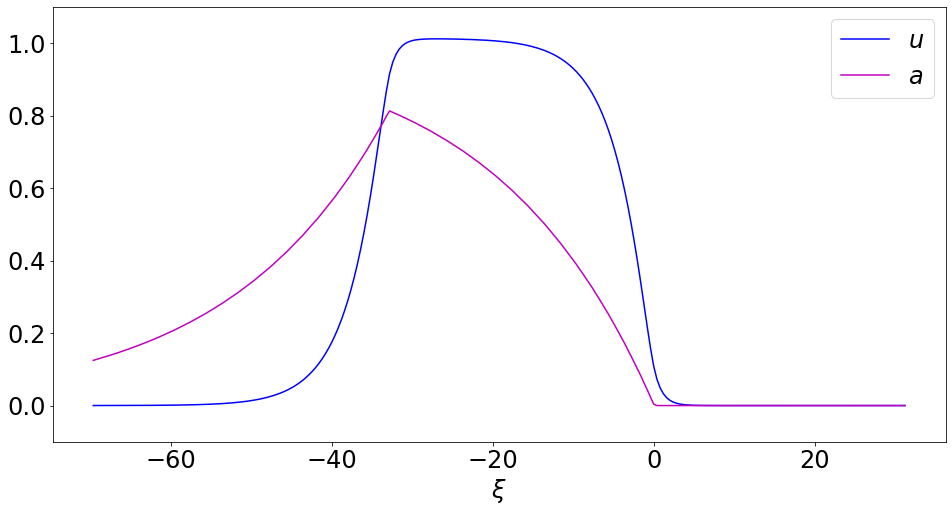

In [11]:
Unumeric = sym.lambdify(ξ, Usub.subs(param_dict))
Anumeric = sym.lambdify(ξ, Asub.subs(param_dict))

plt.figure(figsize=(16, 8))
plt.plot(xs, Us, 'b', label='$u$')
# plt.plot(xs, Unumeric(xs), 'b--')
plt.plot(xs, As, 'm-', label='$a$')
# plt.plot(xs, Anumeric(xs), 'm--')
plt.ylim(-.1, 1.1)

plt.xlabel('$\\xi$')

plt.legend()

# plt.savefig('../reports/report20210603/pulse.png')
# plt.savefig('pulse.eps')

plt.show()

3.9239239239238697
4.18545935079561


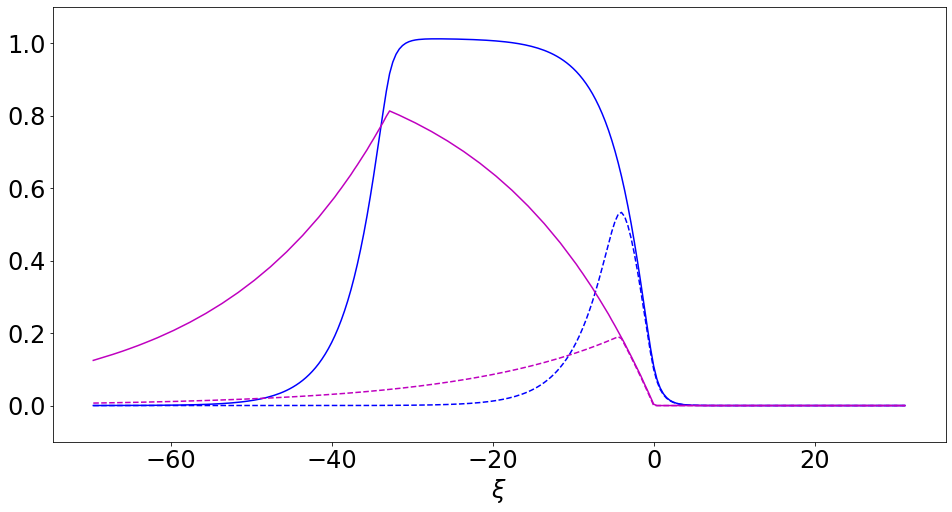

In [6]:
param_dict2 = param_dict.copy()
param_dict2[Δ] = sym.solve(cond1, Δ)[0].subs(param_dict)
print(param_dict2[c])
print(param_dict2[Δ])
Unumeric = sym.lambdify(ξ, Usub.subs(param_dict2))
Anumeric = sym.lambdify(ξ, Asub.subs(param_dict2))

plt.figure(figsize=(16, 8))
plt.plot(xs, Us, 'b')
plt.plot(xs, Unumeric(xs), 'b--')
plt.plot(xs, As, 'm-')
plt.plot(xs, Anumeric(xs), 'm--')
plt.ylim(-.1, 1.1)

plt.xlabel('$\\xi$')

# plt.savefig('../reports/report20210603/pulse2.png')

plt.show()

# Root-finding

In [7]:
E = sym.symbols('E', real=True, positive=True)
Esub = sym.exp(-Δ)
var_vec = sym.Matrix([[E], [c]])
cond1E = cond1.subs(Esub, E)
cond2E = cond2.subs(Esub, E).subs(Esub**(1/μ/c), E**(1/μ/c)).subs(Esub**(1/α/c), E**(1/α/c))
vecF = sym.Matrix([[cond1E],[cond2E]])

var_vec = sym.Matrix([[E],[c]])
param_dict2 = {key:param_dict[key] for key in param_dict if key not in [Δ, c]}
F = sym.lambdify( (E,c),  vecF.T.subs(param_dict2) )
jac = sym.lambdify( (E,c),  vecF.jacobian(var_vec).subs(param_dict2) )

vec = np.array([np.exp(-param_dict[Δ]), param_dict[c]])
for i in range(10):
    print(la.cond(jac(*vec)))
    vec -= la.solve(jac(*vec), F(*vec)[0])


2.0282014018537943e+28
1.2693697593662305e+27
7.639157381573485e+26
3.389129064941727e+25
9.569104430979571e+24
2.047231972992756e+24
4.8223644167607934e+23
1.1338897356268823e+23
2.691553420104771e+22
6.41735706093444e+21


In [8]:
vec

array([3.06733053e-11, 3.15995063e+00])

In [9]:
Δsub = sym.solve(cond1, sym.exp(Δ))[0]
cond_c = cond2.subs(sym.exp(Δ),Δsub).subs(sym.exp(Δ/μ/c),Δsub**(1/μ/c)).subs(sym.exp(Δ/α/c),Δsub**(1/α/c))

In [10]:
cond_c

-\gamma*(1 - (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\alpha*c))) - \theta + 1 - 1/(2*(\mu*c + 1)) + (-2*\mu*\theta*c - 2*\theta + 1)/(2*(\mu*c - 1)) + (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\mu*c))*(\theta - (\mu**2*c**2 + \mu*c/2 - (\mu*c/2 - 1/2)*(-2*\mu*\theta*c - 2*\theta + 1) - 1/2)/(\mu**2*c**2 - 1))

In [11]:
cond_c.diff(c)

\gamma*(-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\alpha*c))*(-2*\mu*\theta*(-2*\mu*\theta*c - 2*\theta + 1)/(\alpha*c*(2*\mu*\theta*c + 2*\theta - 1)**2) + log(-1/(2*\mu*\theta*c + 2*\theta - 1))/(\alpha*c**2)) - \mu*\theta/(\mu*c - 1) + \mu/(2*(\mu*c + 1)**2) - \mu*(-2*\mu*\theta*c - 2*\theta + 1)/(2*(\mu*c - 1)**2) + (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\mu*c))*(\theta - (\mu**2*c**2 + \mu*c/2 - (\mu*c/2 - 1/2)*(-2*\mu*\theta*c - 2*\theta + 1) - 1/2)/(\mu**2*c**2 - 1))*(-2*\theta*(-2*\mu*\theta*c - 2*\theta + 1)/(c*(2*\mu*\theta*c + 2*\theta - 1)**2) + log(-1/(2*\mu*\theta*c + 2*\theta - 1))/(\mu*c**2)) + (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\mu*c))*(2*\mu**2*c*(\mu**2*c**2 + \mu*c/2 - (\mu*c/2 - 1/2)*(-2*\mu*\theta*c - 2*\theta + 1) - 1/2)/(\mu**2*c**2 - 1)**2 - (2*\mu**2*c - 2*\mu*\theta*(-\mu*c/2 + 1/2) - \mu*(-2*\mu*\theta*c - 2*\theta + 1)/2 + \mu/2)/(\mu**2*c**2 - 1))

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: invalid value encountered in power


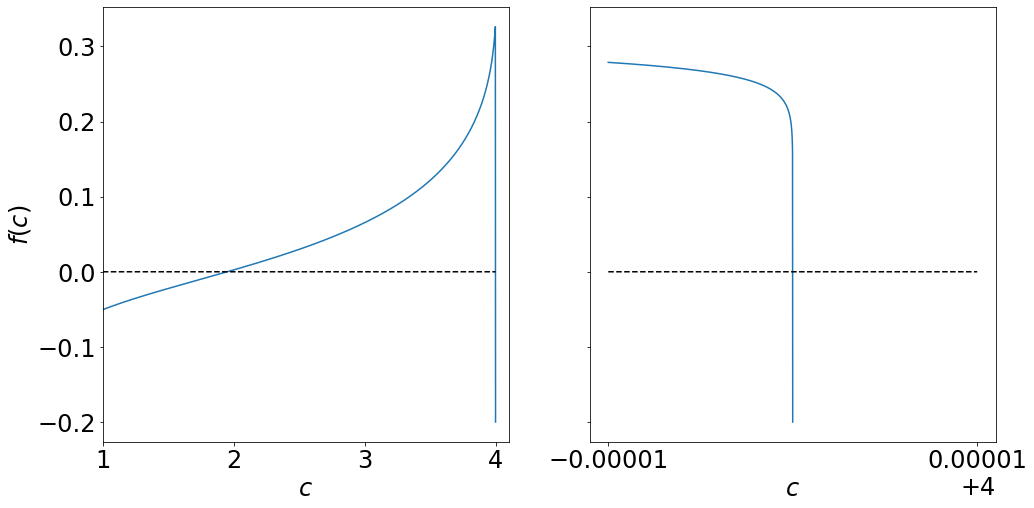

In [12]:
param_dict2 = {key:param_dict[key] for key in param_dict if key not in [Δ, c]}
test = sym.lambdify(c, cond_c.subs(param_dict2))

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
cs = np.linspace(1, 4, 2001)
axes[0].plot(cs, test(cs))
axes[0].plot(cs, 0*cs, 'k--')
axes[0].set_xlim(cs[0], cs[-1]+.1)
axes[0].set_xlabel('$c$')
axes[0].set_ylabel('$f(c)$')

cs = np.linspace(3.99999, 4.00001, 2001)
axes[1].plot(cs, test(cs))
axes[1].plot(cs, 0*cs, 'k--')
axes[1].set_xlabel('$c$')
axes[1].set_xticks([cs[0], cs[-1]])

# plt.savefig('../reports/report20210603/rootfinding.png')

plt.show()

# Export numerical code

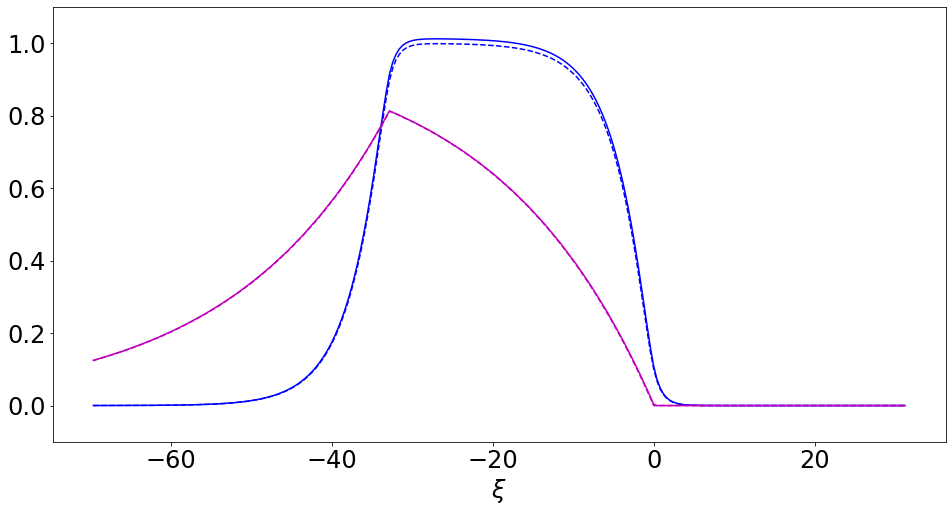

In [13]:
Utest = sym.Heaviside(-ξ-Δ)*Uleft + sym.Heaviside(-ξ)*sym.Heaviside(ξ+Δ)*Umid + sym.Heaviside(ξ)*Uright
Atest = sym.Heaviside(-ξ-Δ)*Aleft + sym.Heaviside(-ξ)*sym.Heaviside(ξ+Δ)*Amid + sym.Heaviside(ξ)*Aright
Unumeric = sym.lambdify(ξ, Utest.subs(param_dict), modules=sympy_modules)
Anumeric = sym.lambdify(ξ, Atest.subs(param_dict), modules=sympy_modules)

plt.figure(figsize=(16, 8))
plt.plot(xs, Us, 'b')
plt.plot(xs, Unumeric(xs), 'b--')
plt.plot(xs, As, 'm-')
plt.plot(xs, Anumeric(xs), 'm--')
plt.ylim(-.1, 1.1)

plt.xlabel('$\\xi$')

plt.show()

In [14]:
code = 'def Unum(ξ, μ, α, γ, θ, Δ, c):\n\treturn ' + py_code(Utest)
print(code)

code = 'def Anum(ξ, μ, α, γ, θ, Δ, c):\n\treturn ' + py_code(Atest)
print(code)

def Unum(ξ, μ, α, γ, θ, Δ, c):
	return // Not supported in C:
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
(1.0/2.0)*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((1.0/2.0)*(-np.exp(Δ)/(μ*c - 1) + 1.0/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((θ + (-( lambda base, exponent: base**exponent )(μ, 2)*( lambda ba

In [15]:
with open('profile.pickle', 'rb') as f:
    xs, Us, As, param_list = pickle.load(f)
    param_keys = ['μ', 'α',  'γ',  'θ', 'Δ', 'c']
    params = {key:val for key,val in zip(param_keys, param_list)}
    
def Unum(ξ, μ, α, γ, θ, Δ, c):
    return (1.0/2.0)*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((1.0/2.0)*(-np.exp(Δ)/(μ*c - 1) + 1.0/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((θ + (-( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + ((1.0/2.0)*μ*c - 1.0/2.0)*np.exp(-Δ) + 1.0/2.0)/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*np.exp(ξ/(μ*c)) + 1 - 1.0/2.0*np.exp(-Δ)*np.exp(-ξ)/(μ*c + 1) + (1.0/2.0)*np.exp(ξ)/(μ*c - 1))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)

def Anum(ξ, μ, α, γ, θ, Δ, c):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)


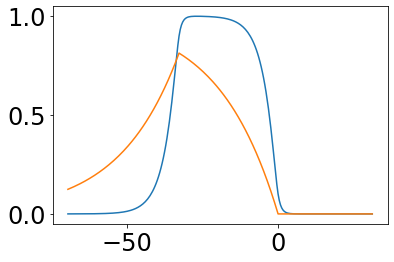

In [16]:
plt.plot(xs, Unum(xs, **params))
plt.plot(xs, Anum(xs, **params))

In [11]:
Uleft

(-exp(\Delta)/(\mu*c - 1) + 1/(\mu*c - 1))*exp(\xi)/2 + (\mu**2*c**2*exp(\Delta/(\mu*c)) - \mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c - 1)*exp(-\Delta)/2 + 1/2)*exp(\xi/(\mu*c))/(\mu**2*c**2 - 1)

In [12]:
Umid

(\theta + (-\mu**2*c**2 - \mu*c/2 + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)/(\mu**2*c**2 - 1))*exp(\xi/(\mu*c)) + 1 - exp(-\Delta)*exp(-\xi)/(2*(\mu*c + 1)) + exp(\xi)/(2*(\mu*c - 1))

In [10]:
Uright

(1 - exp(-\Delta))*exp(-\xi)/(2*(\mu*c + 1))

In [20]:
sym.limit((Uleft-Aleft).diff(ξ), ξ, -Δ).simplify()

(2*\alpha*\mu**2*\theta*c**2*exp(\Delta + \Delta/(\alpha*c)) - 2*\alpha*\mu**2*c**2*exp(\Delta + \Delta/(\alpha*c)) + \alpha*\mu**2*c**2*exp(\Delta/(\mu*c) + \Delta/(\alpha*c)) + \alpha*\mu**2*c**2*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)) + \alpha*\mu*c*exp(\Delta/(\alpha*c)) - \alpha*\mu*c*exp(\Delta + \Delta/(\alpha*c)) + \alpha*\mu*c*exp(\Delta/(\mu*c) + \Delta/(\alpha*c)) - \alpha*\mu*c*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)) - 2*\alpha*\theta*exp(\Delta + \Delta/(\alpha*c)) - \alpha*exp(\Delta/(\alpha*c)) + \alpha*exp(\Delta + \Delta/(\alpha*c)) + 2*\gamma*\mu**3*c**2*exp(\Delta + \Delta/(\mu*c)) - 2*\gamma*\mu**3*c**2*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)) - 2*\gamma*\mu*exp(\Delta + \Delta/(\mu*c)) + 2*\gamma*\mu*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)))*exp(-\Delta - \Delta/(\mu*c) - \Delta/(\alpha*c))/(2*\alpha*\mu*c*(\mu**2*c**2 - 1))

In [21]:
sym.limit((Umid-Amid).diff(ξ), ξ, -Δ).simplify()

(2*\alpha*\mu**2*\theta*c**2*exp(\Delta + \Delta/(\alpha*c)) - 2*\alpha*\mu**2*c**2*exp(\Delta + \Delta/(\alpha*c)) + \alpha*\mu**2*c**2*exp(\Delta/(\mu*c) + \Delta/(\alpha*c)) + \alpha*\mu**2*c**2*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)) + \alpha*\mu*c*exp(\Delta/(\alpha*c)) - \alpha*\mu*c*exp(\Delta + \Delta/(\alpha*c)) + \alpha*\mu*c*exp(\Delta/(\mu*c) + \Delta/(\alpha*c)) - \alpha*\mu*c*exp(\Delta + \Delta/(\mu*c) + \Delta/(\alpha*c)) - 2*\alpha*\theta*exp(\Delta + \Delta/(\alpha*c)) - \alpha*exp(\Delta/(\alpha*c)) + \alpha*exp(\Delta + \Delta/(\alpha*c)) + 2*\gamma*\mu**3*c**2*exp(\Delta + \Delta/(\mu*c)) - 2*\gamma*\mu*exp(\Delta + \Delta/(\mu*c)))*exp(-\Delta - \Delta/(\mu*c) - \Delta/(\alpha*c))/(2*\alpha*\mu*c*(\mu**2*c**2 - 1))

In [22]:
sym.limit((Umid-Amid).diff(ξ), ξ, 0).simplify()

\theta/(\mu*c) - 1/(2*\mu*c) + exp(-\Delta)/(2*\mu*c) + \gamma/(\alpha*c)

In [23]:
sym.limit((Uright-Aright).diff(ξ), ξ, 0).simplify()

(1 - exp(\Delta))*exp(-\Delta)/(2*(\mu*c + 1))